In [77]:
!pip install EMD-signal
!pip install vnstock

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1634
            Open  High   Low  Close  Volume Ticker
Time                                              
2017-06-02  3410  3440  3290   3320    2580    VIB
2017-06-05  3320  3410  3290   3290   39900    VIB
2017-06-06  3310  3320  3290   3320   53340    VIB
2017-06-07  3420  3420  3310   3340   69855    VIB
2017-06-08  3310  3310  3290   3310   50310    VIB
2017-06-09  3290  3310  3290   3290   43100    VIB


<Axes: xlabel='Time'>

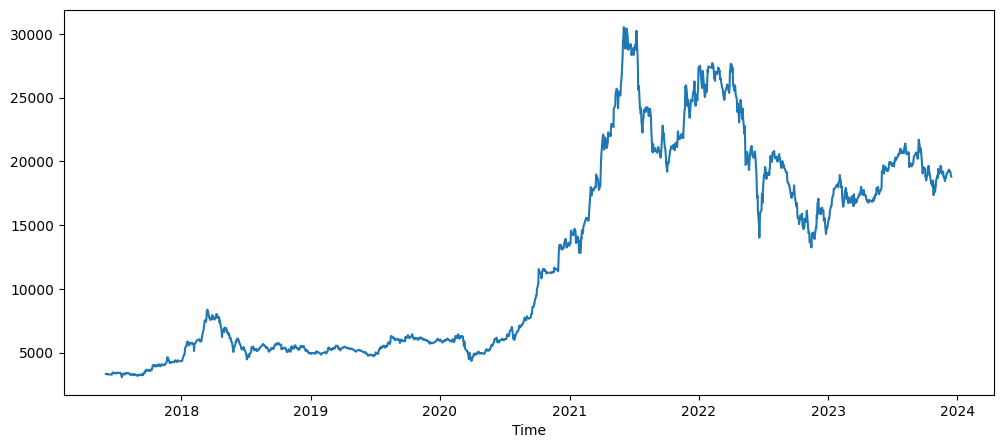

In [79]:
# Import data
VIB = stock_historical_data(symbol = "VIB", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VIB['Close']))
print(pd.DataFrame(VIB.head(6)))
train_dates = VIB.index
plt.figure(figsize=(12, 5))
VIB["Close"].plot()

In [80]:
VIB = VIB.reset_index(drop = True)
df = VIB['Close']
df

0        3320
1        3290
2        3320
3        3340
4        3310
        ...  
1629    19200
1630    19200
1631    19050
1632    18900
1633    18800
Name: Close, Length: 1634, dtype: int64

## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [81]:
from PyEMD import EMD, CEEMDAN

In [82]:
#ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
ceemdan = CEEMDAN(epsilon=0.005, range_thr = 0.005)
ceemdan.noise_seed(seed = 1)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [83]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8
0,2.780031,-2.732754,22.214991,-47.229770,27.050379,-149.581458,1635.946301,1831.552280
1,-27.451767,-4.706262,27.827947,-50.943944,28.047929,-150.586341,1637.056601,1830.755838
2,7.892371,-10.748725,31.257995,-54.125058,29.195239,-151.790206,1638.316782,1830.001603
3,10.938342,9.354548,29.936012,-56.555056,30.506185,-153.197488,1639.727890,1829.289566
4,-1.470256,0.219365,22.105010,-57.945390,31.992350,-154.811560,1641.290767,1828.619715
...,...,...,...,...,...,...,...,...
1629,-56.137564,103.762682,334.606901,-222.699496,-794.028210,3458.128828,-4573.726156,20950.093014
1630,42.588898,47.816702,298.820595,-240.344247,-776.739740,3455.090799,-4570.032136,20942.799129
1631,16.436069,-18.692220,242.725192,-250.107783,-761.421994,3451.743009,-4566.127765,20935.445491
1632,-16.504213,-72.726877,175.736122,-252.399767,-748.209836,3448.086050,-4562.013523,20928.032044


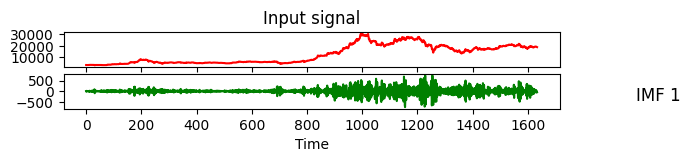

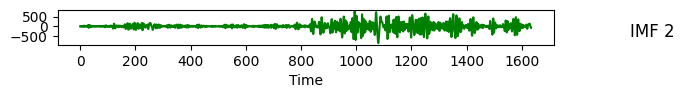

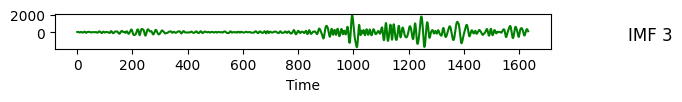

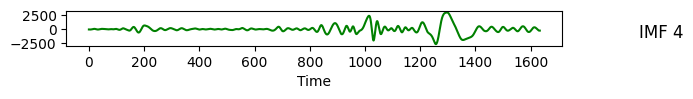

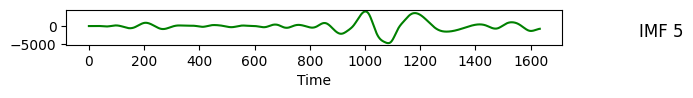

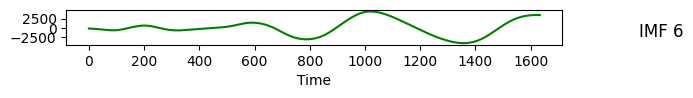

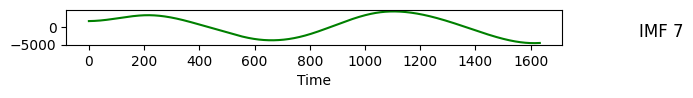

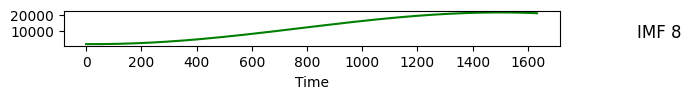

In [84]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [85]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1634, 1)
Residue: (1634, 1)


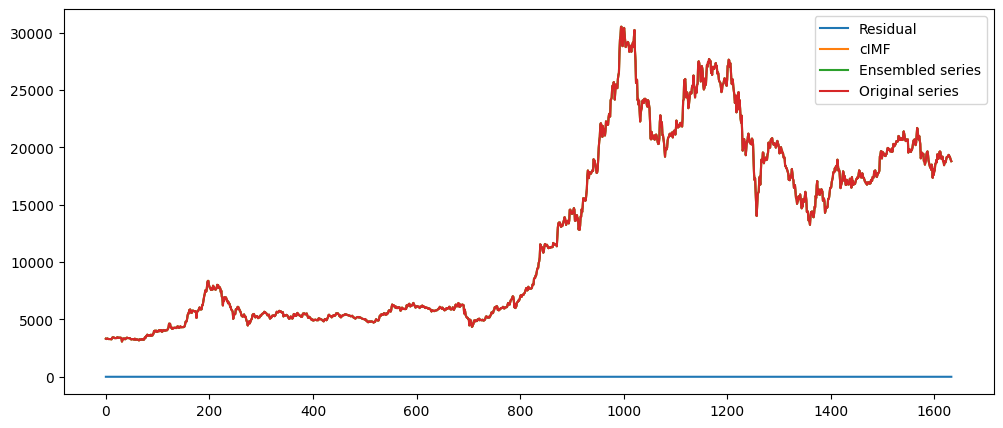

In [86]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

## (B) LSTM
### 0. Tiền xử lý


In [87]:
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

#### 0.1. Scale dữ liệu

In [88]:
# Scale data to 0-1
scaler = MinMaxScaler(feature_range=(0,1))
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
cIMFs_t = cIMFs.T
IMFscale = Scaling(cIMFs_t)

In [89]:
print(IMFscale.shape)

(1634, 8)


#### 0.2. Chia Train test


(1634, 8)
Train:  (1307, 8)
Test:  (327, 8)


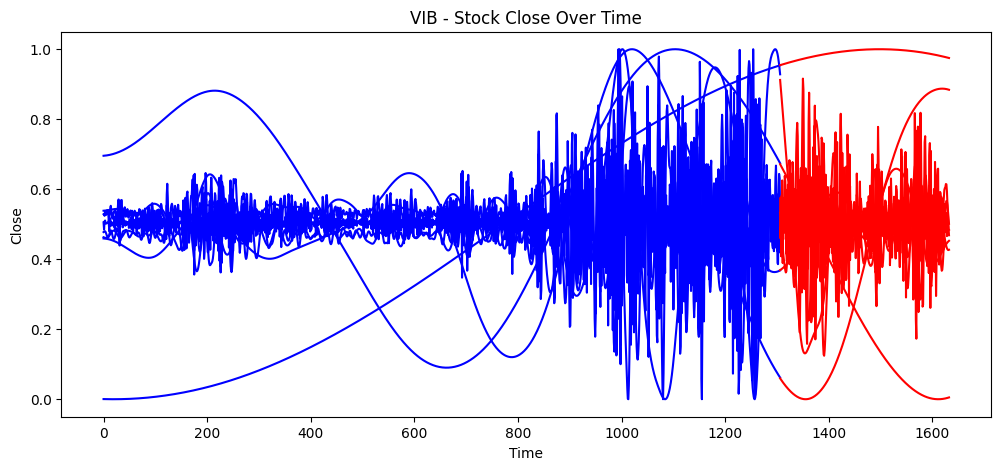

In [90]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.8*IMFscale.shape[0])
test_size = int(0.2*IMFscale.shape[0])
train_data = IMFscale[:train_size]
test_data = IMFscale[train_size:]

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(12,5))

plt.plot(range(train_size), train_data, linestyle='-', color='b')
plt.plot(range(train_size-1,  train_size+test_size), test_data, linestyle='-',  color='r')

plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.show()

In [91]:
# Train X and Y
# For each SAMPLE, we have a matrix of (1, 15, 8)
# consisting of one target, 15 days to look back and 8 features
###===
# For each LABEL, we have a matrix of (1, 8)
# consisting of one target and 8 features
###==
# LSTM is to be conducted parallelly

trainX = []
trainY = []

n_past = 40
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, :]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, :]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
trainY = trainY.reshape(trainY.shape[0], trainY.shape[2])

print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1267, 40, 8)
Y train:  (1267, 8)


In [92]:
# Test X and Y
# For each SAMPLE, we have a matrix of (1, 15, 8)
# consisting of one target, 15 days to look back and 8 features
###===
# For each LABEL, we have a matrix of (1, 8)
# consisting of one target and 8 features
###==
# LSTM is to be conducted parallelly
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, :]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, :]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)
testY = testY.reshape(testY.shape[0], testY.shape[2])

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (287, 40, 8)
Y test:  (287, 8)


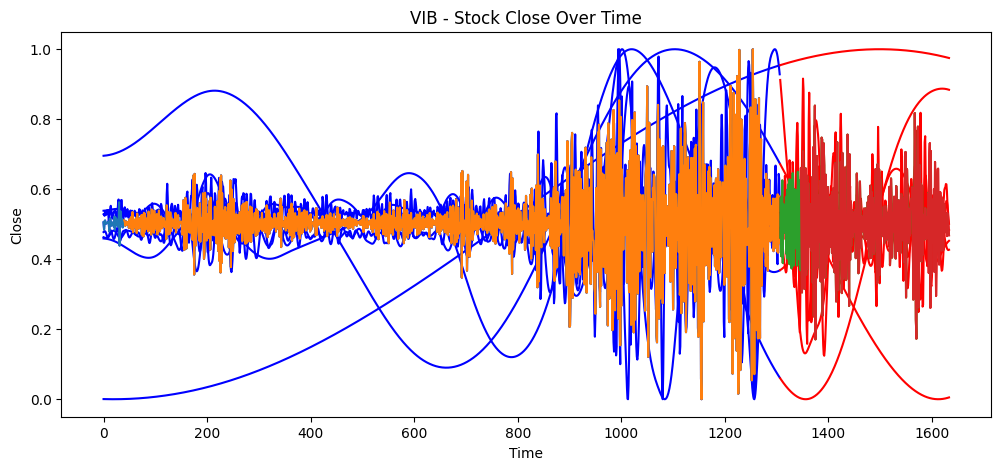

In [93]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(12,5))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')

plt.show()

### 1. Train model

In [94]:
# Tạo model lstm cho việc training
## kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),
               ##bias_regularizer=l2(0.01),
model = Sequential()
model.add(LSTM(100, activation='relu',

               input_shape=(trainX.shape[1], trainX.shape[2]),

               return_sequences=True))
model.add(LSTM(100, activation='relu',

               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainX.shape[2]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 40, 100)           43600     
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 808       
                                                                 
Total params: 124808 (487.53 KB)
Trainable params: 124808 (487.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
history = model.fit(trainX, trainY,epochs = 100, batch_size = 10, validation_split = 0.2, verbose=1)

Epoch 1/100
102/102 [==============================] - 4s 27ms/step - loss: 0.0603 - val_loss: 0.0627
Epoch 2/100
102/102 [==============================] - 2s 24ms/step - loss: 0.0145 - val_loss: 0.0389
Epoch 3/100
102/102 [==============================] - 3s 30ms/step - loss: 0.0101 - val_loss: 0.0327
Epoch 4/100
102/102 [==============================] - 2s 24ms/step - loss: 0.0092 - val_loss: 0.0499
Epoch 5/100
102/102 [==============================] - 4s 39ms/step - loss: 0.0082 - val_loss: 0.0492
Epoch 6/100
102/102 [==============================] - 3s 29ms/step - loss: 0.0077 - val_loss: 0.0528
Epoch 7/100
102/102 [==============================] - 3s 26ms/step - loss: 0.0074 - val_loss: 0.0373
Epoch 8/100
102/102 [==============================] - 2s 24ms/step - loss: 0.0066 - val_loss: 0.0345
Epoch 9/100
102/102 [==============================] - 2s 24ms/step - loss: 0.0064 - val_loss: 0.0491
Epoch 10/100
102/102 [==============================] - 3s 29ms/step - loss: 0.006

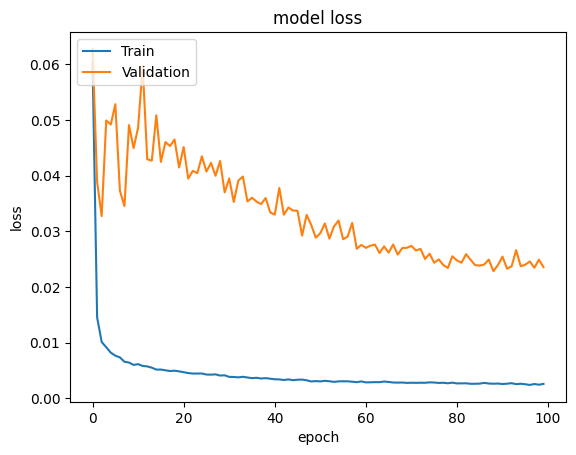

In [96]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 2. Test model

In [97]:
testY.shape

(287, 8)

In [98]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
print(prediction_copies.shape)
y_pred_future = scaler.inverse_transform(prediction)[:]
print(y_pred_future.shape)

9/9 [==============================] - 0s 12ms/step
(287, 64)
(287, 8)


In [99]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

In [100]:
train_sum = train_back.sum(axis = 1).reshape(-1, 1)
test_sum = test_back.sum(axis = 1).reshape(-1, 1)
pred_sum = y_pred_future.sum(axis=1).reshape(-1, 1)

print (train_sum.shape)
print(test_sum.shape)
print(pred_sum.shape)
print(pred_sum)

(1307, 1)
(327, 1)
(287, 1)
[[13552.4375]
 [14159.088 ]
 [14416.151 ]
 [14465.2295]
 [14214.179 ]
 [13613.852 ]
 [13398.658 ]
 [13529.503 ]
 [13576.728 ]
 [13544.262 ]
 [13427.686 ]
 [13236.925 ]
 [13111.837 ]
 [13029.195 ]
 [12962.555 ]
 [12951.345 ]
 [13050.77  ]
 [13077.186 ]
 [12885.391 ]
 [12784.458 ]
 [12612.546 ]
 [12514.628 ]
 [12712.982 ]
 [13295.034 ]
 [14215.099 ]
 [14635.734 ]
 [15416.433 ]
 [15361.885 ]
 [14531.847 ]
 [13943.127 ]
 [13424.59  ]
 [13071.631 ]
 [12887.638 ]
 [13066.85  ]
 [13304.475 ]
 [13612.908 ]
 [13792.492 ]
 [13761.918 ]
 [13164.504 ]
 [12714.371 ]
 [12466.939 ]
 [12372.927 ]
 [12268.384 ]
 [12268.175 ]
 [12311.112 ]
 [12327.682 ]
 [12281.93  ]
 [12239.491 ]
 [12306.636 ]
 [12257.868 ]
 [12172.625 ]
 [12275.542 ]
 [12383.681 ]
 [12316.216 ]
 [12238.605 ]
 [12266.774 ]
 [12192.451 ]
 [12216.513 ]
 [12351.5   ]
 [12210.045 ]
 [11993.599 ]
 [11937.222 ]
 [11792.716 ]
 [11968.3   ]
 [12121.309 ]
 [12471.805 ]
 [12956.01  ]
 [12404.317 ]
 [11947.678 ]
 [1179

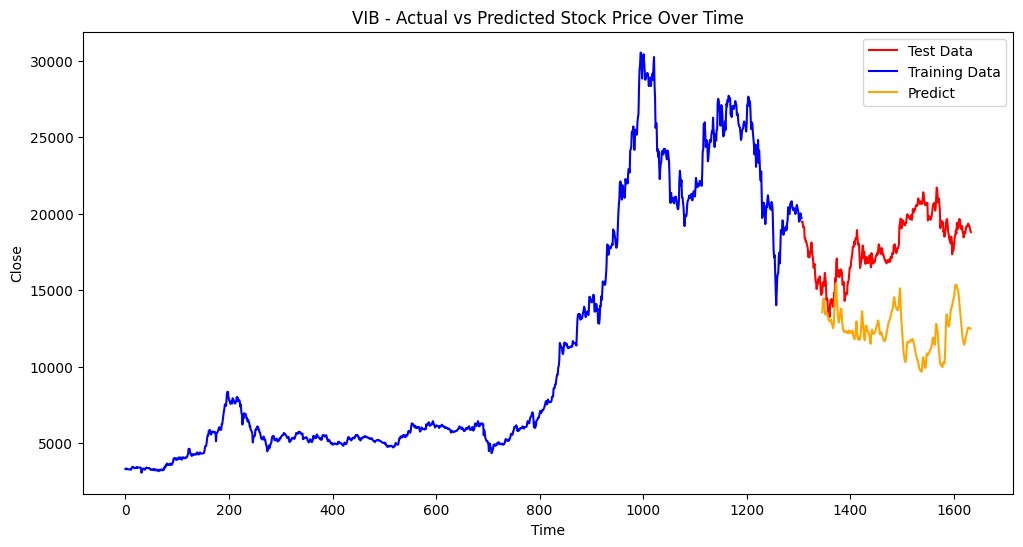

In [101]:
plt.figure(figsize=(12, 6))
n_future = 40

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_sum, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_sum, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  pred_sum, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

### 3. Predict 60 days

In [102]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data
print("Test: ", test_for_forecast.shape)

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-15):])
  print("X shape:",x.shape)
  x = x.reshape(1, x.shape[0], x.shape[1])
  print("X reshape: ",x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  print("Y shape:", y.shape)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  #y_c = np.repeat(y, train_data.shape[1], axis=-1)
  #print("Y copied:",y_c.shape)
  y_pr = scaler.inverse_transform(y)[:]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1, 8)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

Test:  (327, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 212ms/step
Y shape: (1, 8)
(328, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 19ms/step
Y shape: (1, 8)
(329, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 16ms/step
Y shape: (1, 8)
(330, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 16ms/step
Y shape: (1, 8)
(331, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 17ms/step
Y shape: (1, 8)
(332, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 17ms/step
Y shape: (1, 8)
(333, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 17ms/step
Y shape: (1, 8)
(334, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==============================] - 0s 18ms/step
Y shape: (1, 8)
(335, 8)
X shape: (15, 8)
X reshape:  (1, 15, 8)
1/1 [==

In [103]:
print(y_forecast)

[[[-6.79391909e+00 -3.67938499e+01  5.11573067e+01 -8.26320129e+02
   -2.62124237e+02  2.16798364e+03 -2.22381714e+03  1.30245928e+04]]

 [[-5.72146034e+00 -3.41802750e+01  4.72289200e+01 -8.65124023e+02
   -2.50572983e+02  2.10014697e+03 -2.15265991e+03  1.28634883e+04]]

 [[-3.80101681e+00 -2.69608440e+01  5.10107498e+01 -9.15072327e+02
   -2.14704376e+02  2.04058093e+03 -2.02382239e+03  1.27361670e+04]]

 [[-2.43155885e+00 -2.17853546e+01  5.30354042e+01 -9.59124878e+02
   -1.62000732e+02  1.99227551e+03 -1.87179529e+03  1.26234443e+04]]

 [[-2.35647941e+00 -2.09157848e+01  5.11100922e+01 -9.91035767e+02
   -9.81634598e+01  1.95345886e+03 -1.67090588e+03  1.25425498e+04]]

 [[-3.62161565e+00 -2.57436600e+01  4.26491470e+01 -1.01852002e+03
   -3.07628784e+01  1.92084033e+03 -1.43846326e+03  1.25026230e+04]]

 [[-5.57291603e+00 -3.32496071e+01  3.06381664e+01 -1.04716345e+03
    3.11530533e+01  1.90179370e+03 -1.17827808e+03  1.25156572e+04]]

 [[-7.63127375e+00 -4.04679718e+01  1.706

## (C) Plot kiểm tra

In [104]:
forecast_sum = y_forecast.sum(axis = -1)
print(forecast_sum.shape)

(60, 1)


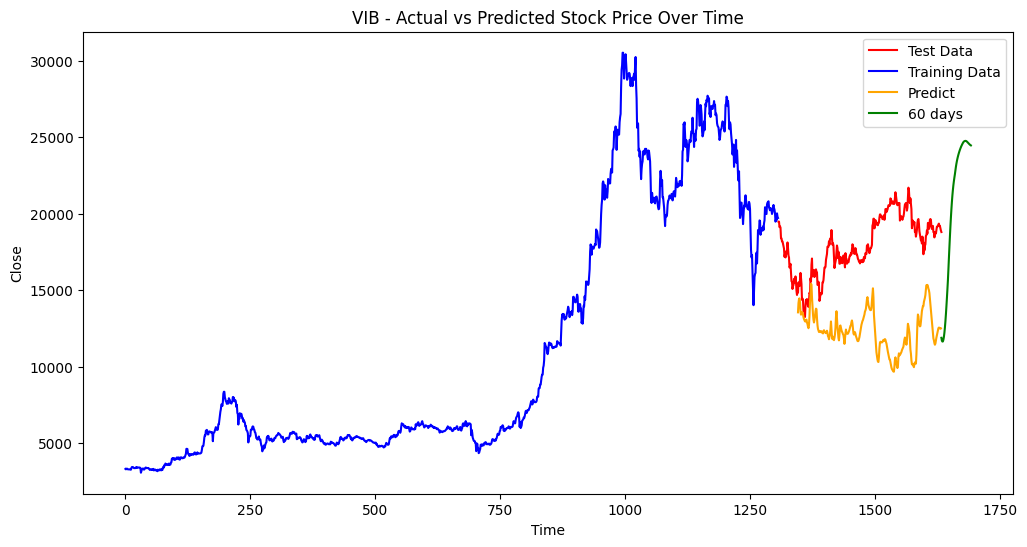

In [105]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_sum, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_sum, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  pred_sum, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), forecast_sum, linestyle='-', color='green', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [107]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

print("RSME: ", RSME(pred_sum, test_sum[n_future:]))
print("MAE: ", MAE(pred_sum, test_sum[n_future:]))
print("MAPE: ", MAPE(pred_sum, test_sum[n_future:]))
print("MSLR: ", MSLE(pred_sum, test_sum[n_future:]))

RSME:  6299.966878311608
MAE:  5691.800934369556
MAPE:  30.404186264185533
MSLR:  0.17551840070999772
